### 0. Import Libraries

In [ ]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import missingno as msno
from collections import defaultdict

# for filling state and city data
import zipcodes
from pprint import pprint

# for filling coordinates data
import requests
import pandas as pd
import io
import csv

# checking similar names
from difflib import get_close_matches

### 1. Data Loading

In [51]:
# load dataset
food_dataset = pd.read_csv("Food_Inspections_20250216.csv")
food_dataset.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,1106427,BLOOMING BUD DAYCARE,BLOOMING BUD DAYCARE,2215789.0,Daycare Combo 1586,Risk 1 (High),5715 N LINCOLN AVE,CHICAGO,IL,60659.0,03/07/2013,License,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.985390,-87.698734,"(41.98538950526786, -87.69873407149943)"
1,2608378,Babas Halal,Babas Halal,2684170.0,Restaurant,Risk 1 (High),7901 S DAMEN AVE,CHICAGO,IL,60620.0,12/03/2024,Complaint,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.750189,-87.672986,"(41.750189342293375, -87.67298583977204)"
2,1106406,FIRST ZABIHA MEAT BAZAAR,FIRST ZABIHA MEAT BAZAAR,2232559.0,Grocery Store,Risk 2 (Medium),2907 W DEVON AVE,CHICAGO,IL,60659.0,02/20/2013,License,Fail,"11. ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, D...",41.997401,-87.702385,"(41.99740137039031, -87.70238538227812)"
3,2609909,HAPPY MARKET,HAPPY MARKET,2912802.0,Grocery Store,Risk 2 (Medium),2334 S WENTWORTH AVE,CHICAGO,IL,60616.0,01/02/2025,Canvass,Pass w/ Conditions,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,41.849954,-87.632094,"(41.84995400192252, -87.63209419559098)"
4,2609927,SAT KAIVAL FOOD INC/SUBWAY,SAT KAIVAL FOOD INC/SUBWAY,2728400.0,Restaurant,Risk 1 (High),1916 S STATE ST,CHICAGO,IL,60616.0,01/02/2025,Canvass,Pass,36. THERMOMETERS PROVIDED & ACCURATE - Comment...,41.856053,-87.627311,"(41.85605269621059, -87.62731125804903)"


In [52]:
# get the data type
food_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287237 entries, 0 to 287236
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Inspection ID    287237 non-null  int64  
 1   DBA Name         287237 non-null  object 
 2   AKA Name         284811 non-null  object 
 3   License #        287219 non-null  float64
 4   Facility Type    282040 non-null  object 
 5   Risk             287149 non-null  object 
 6   Address          287237 non-null  object 
 7   City             287073 non-null  object 
 8   State            287179 non-null  object 
 9   Zip              287198 non-null  float64
 10  Inspection Date  287237 non-null  object 
 11  Inspection Type  287236 non-null  object 
 12  Results          287237 non-null  object 
 13  Violations       207585 non-null  object 
 14  Latitude         286259 non-null  float64
 15  Longitude        286259 non-null  float64
 16  Location         286259 non-null  obje

In [53]:
# get basic statistical description
food_dataset.describe(include='all')

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
count,2.872370e+05,287237,284811,2.872190e+05,282040,287149,287237,287073,287179,287198.000000,287237,287236,287237,207585,286259.000000,286259.000000,286259
unique,NaN,33304,31703,NaN,519,4,30905,86,6,NaN,3813,110,7,206183,NaN,NaN,18493
top,NaN,SUBWAY,SUBWAY,NaN,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,NaN,11/14/2013,Canvass,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,NaN,NaN,"(42.00875076599798, -87.90687413400109)"
freq,NaN,3777,4646,NaN,193855,211761,3057,286102,287164,NaN,185,149444,148027,11,NaN,NaN,3587
mean,1.789447e+06,NaN,NaN,1.755947e+06,NaN,NaN,NaN,NaN,NaN,60628.660116,NaN,NaN,NaN,NaN,41.880779,-87.676337,NaN
std,7.283623e+05,NaN,NaN,9.352139e+05,NaN,NaN,NaN,NaN,NaN,155.440967,NaN,NaN,NaN,NaN,0.080997,0.058353,NaN
min,4.424700e+04,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,10014.000000,NaN,NaN,NaN,NaN,41.644670,-87.906874,NaN
25%,1.327178e+06,NaN,NaN,1.379974e+06,NaN,NaN,NaN,NaN,NaN,60614.000000,NaN,NaN,NaN,NaN,41.832354,-87.707427,NaN
50%,1.981286e+06,NaN,NaN,2.069431e+06,NaN,NaN,NaN,NaN,NaN,60625.000000,NaN,NaN,NaN,NaN,41.891814,-87.666344,NaN
75%,2.472778e+06,NaN,NaN,2.411182e+06,NaN,NaN,NaN,NaN,NaN,60643.000000,NaN,NaN,NaN,NaN,41.939768,-87.634868,NaN


In [54]:
# count number of missing values
food_dataset.isnull().sum()

Inspection ID          0
DBA Name               0
AKA Name            2426
License #             18
Facility Type       5197
Risk                  88
Address                0
City                 164
State                 58
Zip                   39
Inspection Date        0
Inspection Type        1
Results                0
Violations         79652
Latitude             978
Longitude            978
Location             978
dtype: int64

In [55]:
food_dataset.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Results', 'Violations', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

#### Insight:
- DBA Name and AKA Name are pretty similar in terms of word content. We need to confirm if AKA Name is subset of DBA Name.
- License # should have data type integer because it's presented in whole numbers.
- Zip should have data type string (it's a categorical identifier) with 5 digits in US.

### 2. Data Transformation
1. Column name format
2. Change data type of License to string. It's only a unique identifier, should be a whole number.
2. Reformat the Zip data type into string with 5 digits, following US format.
3. Fillthe State, and City columns based on Zip data
4. Risk column content transformation: create new columns (risk_level, inspection_frequency)

#### i. Column Names
- **goal**: change the column name format into lowercase, space in between to _, and remove special characters ("#")
- **reason**: it's more convenient when accessing the data on database.

In [56]:
# Column name changer function
def col_name_changer(df):
    # 1. Change to lower case
    df.columns = df.columns.str.lower()
    # 2. Change space to _
    df.columns = df.columns.str.replace(" ","_")
    # 3. Remove special characters: change # on License # to "num"
    df.columns = df.columns.str.replace("#",'num')
    # 4. Perform strip to ensure no extra white spaces
    df.columns = df.columns.str.strip()
    return df

In [57]:
# Copy dataset
updated_food_dataset = food_dataset.copy()
# Apply function
updated_food_dataset = col_name_changer(updated_food_dataset)

# Show result
updated_food_dataset.columns

Index(['inspection_id', 'dba_name', 'aka_name', 'license_num', 'facility_type',
       'risk', 'address', 'city', 'state', 'zip', 'inspection_date',
       'inspection_type', 'results', 'violations', 'latitude', 'longitude',
       'location'],
      dtype='object')

##### Insight:
- successful transformation

#### ii. License Number Column

In [58]:
# Safely convert float license numbers to strings
updated_food_dataset['license_num'] = updated_food_dataset['license_num'].astype('string')

# Optional: Remove '.0' from floats (e.g., 12345.0 → "12345")
updated_food_dataset['license_num'] = updated_food_dataset['license_num'].str.replace(r'\.0$', '', regex=True)

# show result
updated_food_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287237 entries, 0 to 287236
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   inspection_id    287237 non-null  int64  
 1   dba_name         287237 non-null  object 
 2   aka_name         284811 non-null  object 
 3   license_num      287219 non-null  string 
 4   facility_type    282040 non-null  object 
 5   risk             287149 non-null  object 
 6   address          287237 non-null  object 
 7   city             287073 non-null  object 
 8   state            287179 non-null  object 
 9   zip              287198 non-null  float64
 10  inspection_date  287237 non-null  object 
 11  inspection_type  287236 non-null  object 
 12  results          287237 non-null  object 
 13  violations       207585 non-null  object 
 14  latitude         286259 non-null  float64
 15  longitude        286259 non-null  float64
 16  location         286259 non-null  obje

#### iii. Zip Column
1. Convert zip from float to string form
2. Identify if the data stored are consistent

##### 1. Apply cleaning function on zip

In [59]:
# define the zip data cleaning function
def clean_zip_data(df, zip_col='zip'):
    """
    Enhanced ZIP code cleaner that:
    1. Handles floats/integers (e.g., 60601.0 → "60601")
    2. Preserves leading zeros (e.g., "07001" → "07001")
    3. Removes ZIP+4 extensions (e.g., "60601-1234" → "60601")
    4. Flags invalid ZIPs (non-numeric, wrong length)
    5. Compatible with the `zipcodes` package
    
    Returns:
        DataFrame with:
        - Original column (renamed to zip_raw)
        - Cleaned column (zip_clean)
        - Validation flag (zip_valid)
    """
    df = df.copy()
    
    # Convert to string and clean
    df['zip_clean'] = (
        df[zip_col]
        .astype(str)
        .str.strip()
        .str.replace(r'\.0$', '', regex=True)  # Remove .0 from floats
        .str.extract(r'(\d{5})')[0]            # Extract first 5 digits only
    )
    
    # Standardize to 5-digit strings
    df['zip_clean'] = (
        df['zip_clean']
        .str.zfill(5)                          # Pad with leading zeros
        .where(df['zip_clean'].str.len() == 5)  # Only keep 5-digit codes
        .replace('00000', np.nan)              # Handle all-zero cases
    )
    
    # Validation (matches USPS 5-digit format)
    df['zip_valid'] = (
        df['zip_clean']
        .notna()
        .astype('boolean')
    )
    df['zip_clean'] = df['zip_clean'].astype('string')  # Pandas' StringDtype    
    return df

In [60]:
# implement on dataset
updated_food_dataset = clean_zip_data(updated_food_dataset)

# show result
print(updated_food_dataset[['zip_clean', 'zip_valid']])

       zip_clean  zip_valid
0          60659       True
1          60620       True
2          60659       True
3          60616       True
4          60616       True
...          ...        ...
287232     60618       True
287233     60642       True
287234     60610       True
287235     60612       True
287236     60606       True

[287237 rows x 2 columns]


In [61]:
# show unique values
updated_food_dataset[['zip_clean', 'zip_valid']].dtypes

zip_clean    string[python]
zip_valid           boolean
dtype: object

##### Insight:
- The flagging for zip validity is True or False confirmed.

In [62]:
# After conversion, we need to confirm if all zip values are valid or not
filter = (updated_food_dataset['zip_valid'] == False)

invalid_zips = updated_food_dataset[filter]

# Check if all these cases have NaN zip codes
all_invalid_are_nan = invalid_zips['zip'].isna().all()

print(f"Are all invalid zips NaN? {all_invalid_are_nan}")
print(f"Number of invalid zips: {len(invalid_zips)}")

Are all invalid zips NaN? True
Number of invalid zips: 39


In [63]:
# check the unique values for zip
unique_zips = updated_food_dataset['zip_clean'].unique()

# Print all unique values
print(unique_zips)

<StringArray>
['60659', '60620', '60616', '60610', '60626', '60617', '60611', '60605',
 '60608', '60632',
 ...
 '60477', '60148', '60559', '60202', '60461', '60022', '60423', '60155',
 '60540', '60030']
Length: 128, dtype: string


##### Insight:
- based on domain knowledge, it is known that Chicago-based zip codes always starts from 60.
- we successfully converted the zip data type into string.

##### 2. Zip column final transformation
- Remove zip_valid flag and replace previous zip value with the cleaned version

In [64]:
# removal
updated_food_dataset = updated_food_dataset.drop(columns=['zip','zip_valid'],axis=1)
# change name
updated_food_dataset = updated_food_dataset.rename(columns={'zip_clean':'zip'})

# show result
updated_food_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287237 entries, 0 to 287236
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   inspection_id    287237 non-null  int64  
 1   dba_name         287237 non-null  object 
 2   aka_name         284811 non-null  object 
 3   license_num      287219 non-null  string 
 4   facility_type    282040 non-null  object 
 5   risk             287149 non-null  object 
 6   address          287237 non-null  object 
 7   city             287073 non-null  object 
 8   state            287179 non-null  object 
 9   inspection_date  287237 non-null  object 
 10  inspection_type  287236 non-null  object 
 11  results          287237 non-null  object 
 12  violations       207585 non-null  object 
 13  latitude         286259 non-null  float64
 14  longitude        286259 non-null  float64
 15  location         286259 non-null  object 
 16  zip              287198 non-null  stri

#### iv. State Column
- use zipcodes to fill the missing values in state.

In [65]:
# Prepare function to match the zip code with the zipcode database from zipcodes
def get_zip_info(zip_code, field='state'):
    """Get state/city from ZIP code with proper error handling.
    Args:
        zip_code: Input ZIP (str/int/float)
        field: 'state' or 'city'
    Returns:
        str or None
    """
    if pd.isna(zip_code):
        return None
    try:
        # Convert to string and pad with zeros
        zip_str = str(int(zip_code)).zfill(5) if str(zip_code).isdigit() else str(zip_code)
        matched = zipcodes.matching(zip_str)
        
        if not matched:
            return None
        return matched[0].get(field)  # access the needed field
    
    except Exception as e:
        print(f"Error processing ZIP {zip_code}: {str(e)}")
        return None    

##### 1. Test on missing rows only

In [66]:
# Get rows where 'state' is missing
missing_states_mask = updated_food_dataset['state'].isna()
missing_data = updated_food_dataset[missing_states_mask].copy()  # Isolate missing rows

print(f"Found {len(missing_data)} rows with missing states")

Found 58 rows with missing states


In [67]:
# Then fill the missing data
missing_data['state'] = missing_data.apply(
    lambda row: row['state'] if pd.notna(row['state']) else get_zip_info(row['zip'],'state'), 
    axis=1
)
# rename my state column from changes
missing_data = missing_data.rename(columns={'state':'filled_state'})

In [68]:
# concat with the previous data to see the change from filling
subset_missing = updated_food_dataset[missing_states_mask][['inspection_id','zip','state']]

# get only zip and state data which were previously missing
comparison_df = subset_missing.merge(
    missing_data[['inspection_id', 'filled_state']],
    on='inspection_id',
    how='left'
)

# 4. Add status column to see changes
comparison_df['status'] = np.where(
    comparison_df['filled_state'].notna(),
    'Filled',
    'Still Missing'
)

# Show results
print(f"Filled {len(comparison_df[comparison_df['status'] == 'Filled'])} states")
comparison_df.head(60)

Filled 58 states


,inspection_id,zip,state,filled_state,status
0,2593910,60642,NaN,IL,Filled
1,2230177,60642,NaN,IL,Filled
2,2574703,60642,NaN,IL,Filled
3,2573839,60642,NaN,IL,Filled
4,2523869,60642,NaN,IL,Filled
5,2522099,60642,NaN,IL,Filled
6,2369659,60642,NaN,IL,Filled
7,2290662,60642,NaN,IL,Filled
8,2181740,60642,NaN,IL,Filled
9,2116429,60642,NaN,IL,Filled


##### Insight:
- It's correct filling. Already confirmed through internet search that the zip correctly identified IL state.

##### 2.Implement to whole dataset

In [69]:
# apply to the whole dataset
updated_food_dataset['state'] = updated_food_dataset.apply(
    lambda row: row['state'] if pd.notna(row['state']) else get_zip_info(row['zip'],'state'), 
    axis=1
)

In [70]:
# show result
updated_food_dataset.isnull().sum()

inspection_id          0
dba_name               0
aka_name            2426
license_num           18
facility_type       5197
risk                  88
address                0
city                 164
state                  0
inspection_date        0
inspection_type        1
results                0
violations         79652
latitude             978
longitude            978
location             978
zip                   39
dtype: int64

##### Insight:
- All missing values in state column is sorted.

#### v. City Column
- implement the same function as State Column.

##### 1. Test on missing rows

In [71]:
# Get rows where 'state' is missing
missing_city_mask = updated_food_dataset['city'].isna()
missing_city_data = updated_food_dataset[missing_city_mask].copy()  # Isolate missing rows

print(f"Found {len(missing_city_data)} rows with missing city")

Found 164 rows with missing city


In [72]:
missing_city_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 164 entries, 1104 to 287067
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   inspection_id    164 non-null    int64  
 1   dba_name         164 non-null    object 
 2   aka_name         152 non-null    object 
 3   license_num      164 non-null    string 
 4   facility_type    146 non-null    object 
 5   risk             161 non-null    object 
 6   address          164 non-null    object 
 7   city             0 non-null      object 
 8   state            164 non-null    object 
 9   inspection_date  164 non-null    object 
 10  inspection_type  164 non-null    object 
 11  results          164 non-null    object 
 12  violations       70 non-null     object 
 13  latitude         161 non-null    float64
 14  longitude        161 non-null    float64
 15  location         161 non-null    object 
 16  zip              128 non-null    string 
dtypes: float64(2), 

In [73]:
# Then fill the missing data
missing_city_data['city'] = missing_city_data.apply(
    lambda row: row['city'] if pd.notna(row['city']) else get_zip_info(row['zip'],'city'), 
    axis=1
)
# rename my state column from changes
missing_city_data = missing_city_data.rename(columns={'city':'filled_city'})

missing_city_data.head(20)

,inspection_id,dba_name,aka_name,license_num,facility_type,risk,address,filled_city,state,inspection_date,inspection_type,results,violations,latitude,longitude,location,zip
1104,2603891,TASTE OF ENGLEWOOD INCORPORATED,TASTE OF ENGLEWOOD INCORPORATED,2862480,Restaurant,Risk 1 (High),754 W GARFIELD,Chicago,IL,10/02/2024,Non-Inspection,No Entry,NaN,41.794415,-87.644892,"(41.79441531175851, -87.6448915555911)",60609
2471,2590385,MR TACO MEX,MR TACO MEX,2952607,Restaurant,Risk 1 (High),10656 S TORRENCE AVE,Chicago,IL,03/01/2024,License,Pass w/ Conditions,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.701120,-87.559724,"(41.70112036721256, -87.55972431384708)",60617
4533,2359805,LAZY CAMEL & WESTERN WINE & SPIRITS,LAZY CAMEL & WESTERN WINE & SPIRITS,2698241,Grocery Store,Risk 3 (Low),2218-2222 N WESTERN AVE,Chicago,IL,02/04/2020,License Re-Inspection,Pass,"38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...",41.922312,-87.687709,"(41.922312062185554, -87.68770889778496)",60647
4873,2592491,COCO'S FAMOUS FRIED LOBSTER,COCO'S FAMOUS FRIED LOBSTER,2962034,NaN,Risk 1 (High),8118 S STONY ISLAND AVE,Chicago,IL,04/10/2024,License,No Entry,NaN,41.747241,-87.586025,"(41.74724060201805, -87.5860251882879)",60617
5545,2577721,LA MICHOACANA,LA MICHOACANA,2881818,Restaurant,Risk 2 (Medium),3701 W 26th ST,Chicago,IL,06/22/2023,Complaint,Fail,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,41.844240,-87.717290,"(41.844239638421165, -87.71729018108152)",60623
6043,2589947,MR TACO MEX,MR TACO MEX,2952607,Restaurant,Risk 1 (High),10656 S TORRENCE AVE,Chicago,IL,02/23/2024,License,Not Ready,NaN,41.701120,-87.559724,"(41.70112036721256, -87.55972431384708)",60617
7311,2359766,LAZY CAMEL & WESTERN WINE & SPIRITS,LAZY CAMEL & WESTERN WINE & SPIRITS,2698241,Grocery Store,Risk 3 (Low),2218-2222 N WESTERN AVE,Chicago,IL,01/31/2020,License Re-Inspection,Fail,"38. INSECTS, RODENTS, & ANIMALS NOT PRESENT - ...",41.922312,-87.687709,"(41.922312062185554, -87.68770889778496)",60647
8217,2582280,GARFIELD EXPRESS,NaN,0,NaN,NaN,43 N HOMAN,None,IL,09/25/2023,Canvass,Out of Business,NaN,41.882211,-87.710899,"(41.882211292040566, -87.7108986080365)",<NA>
12431,2556891,"DONERMEN, LLC","DONERMEN, LLC",2840766,Mobile Food Preparer,Risk 2 (Medium),135 N KEDZIE,Chicago,IL,06/07/2022,License Re-Inspection,Pass,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...",41.883905,-87.706059,"(41.88390509704504, -87.70605925083947)",60612
13952,2523869,PURE GREEN,PURE GREEN,2797044,Restaurant,Risk 2 (Medium),1533 N MILWAUKEE,Chicago,IL,08/10/2021,License,Not Ready,NaN,41.909454,-87.675796,"(41.9094539015706, -87.6757962173346)",60642


In [74]:
# concat with the previous data to see the change from filling
subset_city_missing = updated_food_dataset[missing_city_mask][['inspection_id','zip','state','city']]

# get only zip and state data which were previously missing
comparison_city_df = subset_city_missing.merge(
    missing_city_data[['inspection_id', 'filled_city']],
    on='inspection_id',
    how='left'
)
# 4. Add status column to see changes
comparison_city_df['status'] = np.where(
    comparison_city_df['filled_city'].notna(),
    'Filled',
    'Still Missing'
)

# # Show results
print(f"Filled {len(comparison_city_df[comparison_city_df['status'] == 'Filled'])} cities")
comparison_city_df.head(165)

Filled 128 cities


,inspection_id,zip,state,city,filled_city,status
0,2603891,60609,IL,NaN,Chicago,Filled
1,2590385,60617,IL,NaN,Chicago,Filled
2,2359805,60647,IL,NaN,Chicago,Filled
3,2592491,60617,IL,NaN,Chicago,Filled
4,2577721,60623,IL,NaN,Chicago,Filled
...,...,...,...,...,...,...
159,2594631,60623,IL,NaN,Chicago,Filled
160,2607506,60646,IL,NaN,Chicago,Filled
161,2581000,<NA>,IL,NaN,None,Still Missing
162,2610640,60607,IL,NaN,Chicago,Filled


In [75]:
# show the zipcodes with missing cities
comparison_city_df[comparison_city_df['status']=='Still Missing'].zip.unique()

<StringArray>
[<NA>]
Length: 1, dtype: string

In [76]:
# checking number of missing data left
comparison_city_df.isnull().sum()

inspection_id      0
zip               36
state              0
city             164
filled_city       36
status             0
dtype: int64

##### Insight:
- The remaining data loss is only from missing zip code values (36 rows).

##### 2. Implement on full dataset

In [77]:
# apply to the whole dataset
updated_food_dataset['city'] = updated_food_dataset.apply(
    lambda row: row['city'] if pd.notna(row['city']) else get_zip_info(row['zip'],'city'), 
    axis=1
)

In [78]:
# check number of missing values
updated_food_dataset.isnull().sum()

inspection_id          0
dba_name               0
aka_name            2426
license_num           18
facility_type       5197
risk                  88
address                0
city                  36
state                  0
inspection_date        0
inspection_type        1
results                0
violations         79652
latitude             978
longitude            978
location             978
zip                   39
dtype: int64

#### vi. Risk Column
- **goal**: transform risk data into risk_level and inspection_frequency
- **reason**: based on the metadata, it's found that risk level order highest to lowest is 1 to 3. this risk level is tied to how frequent the inspection done from "High", "Medium", to "Low".

In [79]:
# Prepare function
def risk_column_transformation(df):
    # 1. Create new columns and perform the splitting under pattern # Risk "risk_level" "(inspection_frequency)"
    df[['risk_level','inspection_frequency']] = df['risk'].str.extract(r'Risk (\d+) \((.*?)\)')
    
    # 2. Convert risk_level to numeric type
    df['risk_level'] = pd.to_numeric(df['risk_level'])
    
    return df

In [80]:
# Copy dataset
check_risk_food_dataset = updated_food_dataset.copy()

# Apply function
check_risk_food_dataset = risk_column_transformation(check_risk_food_dataset)

# Show result
check_risk_food_dataset[['risk','risk_level','inspection_frequency']].head()

,risk,risk_level,inspection_frequency
0,Risk 1 (High),1.0,High
1,Risk 1 (High),1.0,High
2,Risk 2 (Medium),2.0,Medium
3,Risk 2 (Medium),2.0,Medium
4,Risk 1 (High),1.0,High


In [81]:
# Ensure it's consistent
check_risk_food_dataset[['risk','risk_level','inspection_frequency']].value_counts()

risk             risk_level  inspection_frequency
Risk 1 (High)    1.0         High                    211761
Risk 2 (Medium)  2.0         Medium                   52347
Risk 3 (Low)     3.0         Low                      22973
Name: count, dtype: int64

##### Insight:
- it's consistent, so we can safely apply to our dataset and remove the risk column.

In [82]:
# Implement change on the dataset
updated_food_dataset = risk_column_transformation(updated_food_dataset)
updated_food_dataset = updated_food_dataset.drop(columns='risk',axis=1)

# Show result
updated_food_dataset.head()

,inspection_id,dba_name,aka_name,license_num,facility_type,address,city,state,inspection_date,inspection_type,results,violations,latitude,longitude,location,zip,risk_level,inspection_frequency
0,1106427,BLOOMING BUD DAYCARE,BLOOMING BUD DAYCARE,2215789,Daycare Combo 1586,5715 N LINCOLN AVE,CHICAGO,IL,03/07/2013,License,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.985390,-87.698734,"(41.98538950526786, -87.69873407149943)",60659,1.0,High
1,2608378,Babas Halal,Babas Halal,2684170,Restaurant,7901 S DAMEN AVE,CHICAGO,IL,12/03/2024,Complaint,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.750189,-87.672986,"(41.750189342293375, -87.67298583977204)",60620,1.0,High
2,1106406,FIRST ZABIHA MEAT BAZAAR,FIRST ZABIHA MEAT BAZAAR,2232559,Grocery Store,2907 W DEVON AVE,CHICAGO,IL,02/20/2013,License,Fail,"11. ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, D...",41.997401,-87.702385,"(41.99740137039031, -87.70238538227812)",60659,2.0,Medium
3,2609909,HAPPY MARKET,HAPPY MARKET,2912802,Grocery Store,2334 S WENTWORTH AVE,CHICAGO,IL,01/02/2025,Canvass,Pass w/ Conditions,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,41.849954,-87.632094,"(41.84995400192252, -87.63209419559098)",60616,2.0,Medium
4,2609927,SAT KAIVAL FOOD INC/SUBWAY,SAT KAIVAL FOOD INC/SUBWAY,2728400,Restaurant,1916 S STATE ST,CHICAGO,IL,01/02/2025,Canvass,Pass,36. THERMOMETERS PROVIDED & ACCURATE - Comment...,41.856053,-87.627311,"(41.85605269621059, -87.62731125804903)",60616,1.0,High


In [83]:
# show result
updated_food_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287237 entries, 0 to 287236
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   inspection_id         287237 non-null  int64  
 1   dba_name              287237 non-null  object 
 2   aka_name              284811 non-null  object 
 3   license_num           287219 non-null  string 
 4   facility_type         282040 non-null  object 
 5   address               287237 non-null  object 
 6   city                  287201 non-null  object 
 7   state                 287237 non-null  object 
 8   inspection_date       287237 non-null  object 
 9   inspection_type       287236 non-null  object 
 10  results               287237 non-null  object 
 11  violations            207585 non-null  object 
 12  latitude              286259 non-null  float64
 13  longitude             286259 non-null  float64
 14  location              286259 non-null  object 
 15  

##### Insight:
- conversion is successful

#### vii. Longitude and Latitude Columns
- Use GeoCoder Census Data 2010.

In [ ]:
# Fill missing values
def geocode_missing_coordinates(df: pd.DataFrame) -> pd.DataFrame:
    """
    Geocode missing latitude/longitude data using Census API
    Follows exact workflow from your code example
    
    Parameters:
        df: DataFrame containing address components and missing coordinates
    
    Returns:
        DataFrame with updated latitude/longitude for previously missing rows
    """
    # --- 1. Prepare Missing Data ---
    # Get rows where coordinates are missing
    missing_mask = df['latitude'].isna() | df['longitude'].isna()
    missing_data = df[missing_mask][['address','city','state','latitude','longitude','location','zip']].copy()
    
    if len(missing_data) == 0:
        print("No missing coordinates to geocode")
        return df
    
    # Format addresses
    missing_data['address'] = missing_data['address'].apply(format_address)
    
    # --- 2. Prepare API Input ---
    geocoder_df = pd.DataFrame({
        'street': missing_data['address'],
        'city': missing_data['city'],
        'state': missing_data['state'],
        'zip': missing_data['zip']
    }).reset_index(drop=True)
    
    # Save to CSV
    with open('my_geocoder_input.csv', 'w', encoding='utf-8') as f:
        geocoder_df.to_csv(f, index=True, header=False)
    
    # --- 3. Call Census API ---
    url = 'https://geocoding.geo.census.gov/geocoder/geographies/addressbatch'
    try:
        with open('my_geocoder_input.csv', 'rb') as f:
            files = {'addressFile': ('my_geocoder_input.csv', f, 'text/csv')}
            payload = {
                'benchmark': 'Public_AR_Current',
                'vintage': 'Census2010_Current',
                'format': 'json'
            }
            response = requests.post(url, files=files, data=payload, timeout=30)
        
        if response.status_code != 200:
            raise Exception(f"API Error {response.status_code}: {response.text[:200]}")
            
        # Save raw response
        with open("geocoded_results.csv", "wb") as f:
            f.write(response.content)
            
    except Exception as e:
        print(f"Geocoding failed: {str(e)}")
        return df
    
    # --- 4. Process Results ---
    try:
        # Load and parse results
        result_df = pd.read_csv(
            'geocoded_results.csv',
            header=None,
            quotechar='"',
            names=[
                "ID", "input_address", "match_status", "match_type",
                "matched_address", "location", "tigerline_id", "side",
                "statefips", "countyfips", "tractcode", "blockcode"
            ]
        )
        
        # Filter successful matches
        matched = result_df[result_df['match_status'] == "Match"].copy()
        matched[['longitude', 'latitude']] = matched['location'].str.split(',', expand=True).astype(float)
        
    except Exception as e:
        print(f"Failed to process results: {str(e)}")
        return df
    
    # --- 5. Merge Results Back ---
    # Create matching keys
    missing_data['full_address'] = (
        missing_data['address'] + ', ' + 
        missing_data['city'] + ', ' + 
        missing_data['state'] + ', ' + 
        missing_data['zip'].astype(str)
    )
    
    # Create coordinate mapping
    coord_map = {
        row['input_address']: (row['latitude'], row['longitude'], row['location'])
        for _, row in matched.iterrows()
    }
    
    # Update coordinates in missing data
    missing_data['latitude'] = missing_data['full_address'].map(
        lambda x: coord_map.get(x, (None, None, None))[0]
    )
    missing_data['longitude'] = missing_data['full_address'].map(
        lambda x: coord_map.get(x, (None, None, None))[1]
    )
    missing_data['location'] = missing_data['full_address'].map(
        lambda x: coord_map.get(x, (None, None, None))[2]
    )
    
    # --- 6. Update Original DataFrame ---
    # Update only the rows that were missing coordinates
    df.update(missing_data[['latitude', 'longitude', 'location']])
    
    return df

In [ ]:
# apply on updated dataset
updated_food_dataset = geocode_missing_coordinates(updated_food_dataset)

### 3. Exploratory Data Analysis
- Profiling only

#### 1. Profiling Risk Level and Inspection Frequency
- risk_level and inspection_frequency should be aligned. They are originated from the same source.

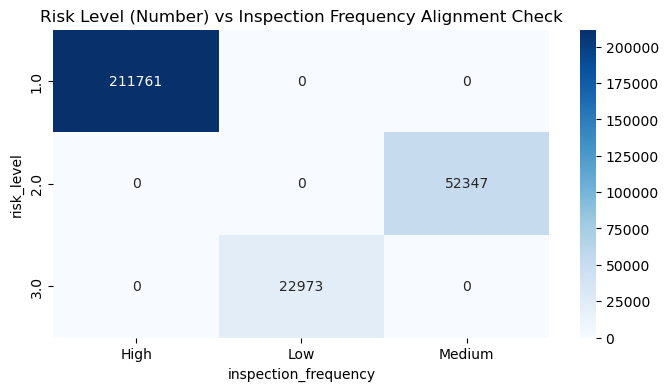

In [84]:
# Cross-tabulation to verify alignment
cross_tab = pd.crosstab(
    updated_food_dataset['risk_level'], 
    updated_food_dataset['inspection_frequency'],
    margins=True
)

plt.figure(figsize=(8, 4))
sns.heatmap(cross_tab.iloc[:-1, :-1], annot=True, fmt='d', cmap='Blues')
plt.title("Risk Level (Number) vs Inspection Frequency Alignment Check")
plt.show()

##### Insight:
1. The alignment of the values are confirmed.
- Risk level = 1 means high inspection frequency.
- Risk level = 2 means medium inspection frequency.
- Risk level = 3 means low inspection frequency.
2. The inspection data suggested a major proportion of establishments has **high inspection frequency**.

#### 2. Profiling Zip
- check most frequent zip codes appearing in the dataset
- zip length analysis validation

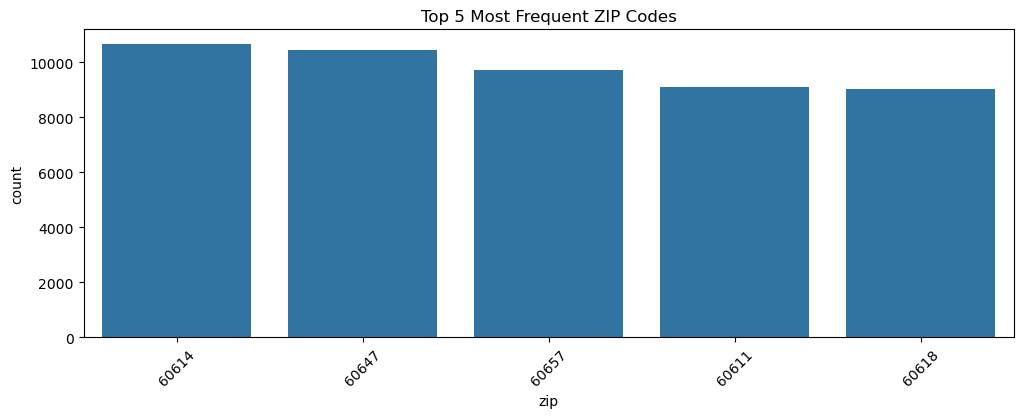

In [88]:
# show most frequent zip codes
plt.figure(figsize=(12, 4))
sns.countplot(data=updated_food_dataset, x='zip', order=updated_food_dataset['zip'].value_counts().iloc[:5].index)  # Top 20 ZIPs
plt.title("Top 5 Most Frequent ZIP Codes")
plt.xticks(rotation=45)
plt.show()

Text(0.5, 1.0, 'ZIP Code Length Distribution')

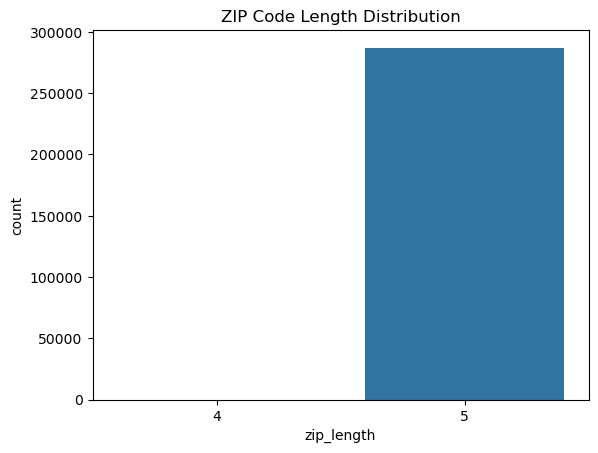

In [89]:
# ensure zip length consistent
consistent_zip_length = updated_food_dataset.copy()
consistent_zip_length['zip_length'] = consistent_zip_length['zip'].astype(str).str.len()
sns.countplot(data=consistent_zip_length, x='zip_length')
plt.title("ZIP Code Length Distribution")

#### 3. Profiling State

In [ ]:
# show the table
state_profile = (
    updated_food_dataset['state']
    .value_counts(dropna=False)
    .rename("Count")
    .to_frame()
    .assign(Percentage=lambda x: (x['Count'] / len(updated_food_dataset)).round(2))
    .rename_axis('State')
    .reset_index()
)
display(state_profile)

,State,Count,Percentage
0,IL,287222,1.0
1,IN,10,0.0
2,CA,2,0.0
3,CO,1,0.0
4,NY,1,0.0
5,WI,1,0.0


##### Insight:
- While most data was originated from IL, there were also a few data coming from other states (IN, CA, CO,NY, and WI).

#### 4. Profiling State, Zip, City Consistency

In [94]:
# Find ZIPs mapped to multiple states (invalid)
zip_state_violations = updated_food_dataset.groupby('zip')['state'].nunique()
anomalous_zips = zip_state_violations[zip_state_violations > 1]
print(f"ZIPs with conflicting states: {len(anomalous_zips)}")

# Show examples
display(updated_food_dataset[updated_food_dataset['zip'].isin(anomalous_zips.index)]
        .sort_values('zip')[['zip', 'state', 'city']].head(10))

ZIPs with conflicting states: 0


,zip,state,city


##### Insight:
- no invalid known zip data which mapped to multiple states

#### 5. Checking City and State Spelling Variations

In [97]:
sample_cities = updated_food_dataset['city'].dropna().unique()
for city in sample_cities[:5]:  # Check first 5 for demo
    matches = get_close_matches(city, sample_cities, n=5, cutoff=0.8)
    if len(matches) > 1:
        print(f"Potential duplicates for '{city}': {matches}")

Potential duplicates for 'CHICAGO': ['CHICAGO', 'CHICAGOO', 'CHICAGOI', 'CHICAGOC', 'CHICAGO.']
Potential duplicates for 'chicago': ['chicago', 'Chicago']
Potential duplicates for 'Chicago': ['Chicago', 'chicago', 'CHicago']
Potential duplicates for 'CHICAGO.': ['CHICAGO.', 'CHICAGO', 'CHICAGOO', 'CHICAGOI', 'CHICAGOC']


In [98]:
sample_states = updated_food_dataset['state'].dropna().unique()
for state in sample_states[:5]:  # Check first 5 for demo
    matches = get_close_matches(city, sample_states, n=5, cutoff=0.8)
    if len(matches) > 1:
        print(f"Potential duplicates for '{state}': {matches}")

##### Insight:
- there are misspellings for city column.